How to retrieve data from Twitter with Tweepy?

In [ ]:
import tweepy 
import pandas as pd

# You need to create a Twitter Developer Account to get the consumer keys and access tokens.
# See this page for more details: https://sites.google.com/site/gsudatavis/home/notes-on-social-media-data-analysis-and-visualization
auth = tweepy.OAuthHandler("API", "API secret")
auth.set_access_token("access token", "token serect")

api = tweepy.API(auth)

# Get my and my friend's most recent tweets
public_tweets = api.home_timeline()
for tweet in public_tweets:
    print(tweet.text)

User based analysis

In [ ]:
# Find user information 
user = api.get_user("GeorgiaStateU")
print(user.screen_name)
print(user.followers_count)
print(user.friends_count)
print(user.location)

Find friends and followers of a user and build an edge list, which can be used to create a social network diagram. 

In [ ]:
# Create an empty edge list
edge_list = pd.DataFrame(columns = ["source", "target"])

# Get a list of friends and friends of the friends
gsu_friends = api.friends("GeorgiaStateU")
for friend in gsu_friends[0:5]: # Only retrieve the first 5 friends
    print(friend.screen_name)
    print(friend.location)
    print("\n")
    # Create an edge for this connection and add it to the edge list. 
    edge_list = edge_list.append({'source' : "GeorgiaStateU", 'target' : friend.screen_name} , ignore_index=True)    
    # Get friends of the friend and create edges for the connections. 
    for friend_of_friend in api.friends(friend.screen_name)[0:5]: # Only retrieve the first 2 friends of the friend 
        edge_list = edge_list.append({'source' : friend.screen_name, 'target' : friend_of_friend.screen_name} , ignore_index=True)
    
edge_list

In [ ]:
# Get a list of followers and follower of the followers
gsu_followers = api.followers("GeorgiaStateU")
for follower in gsu_followers[0:5]:
    #print(follower.screen_name)
    #print(follower.location)
    #print("\n")
    
    # Create an edge for this connection
    edge_list = edge_list.append({'source' : follower.screen_name, 'target' : "GeorgiaStateU"} , ignore_index=True)
    # Get followers of the follower and create edges for the connections. 
    for follower_of_follower in api.followers(follower.screen_name)[0:2]:
        edge_list = edge_list.append({'source' : follower_of_follower.screen_name, 'target' : follower.screen_name} , ignore_index=True)
    
edge_list

# You can use NetworkX function from_pandas_edgelist() to create a graph from the Pandas edge list. 
# For more details, see https://networkx.github.io/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_edgelist.html#networkx.convert_matrix.from_pandas_edgelist

Content based analysis

In [ ]:
# Retrieve a user's recent tweets 
gsu_tweets = api.user_timeline("GeorgiaStateU")
for tweet in gsu_tweets:
    print(tweet.text)

In [ ]:
# Check rate limits
api.rate_limit_status()

In [ ]:
# Get a user's favorites
gsu_favorites = api.favorites("GeorgiaStateU")
for favorite in gsu_favorites:
    print(favorite.text)

In [ ]:
# Get available trends
trends = api.trends_available()
for trend in trends:
    print("%s, woeid %s" %(trend['name'], trend['woeid']))

In [ ]:
# Find out what is trending at certain place. You need to use WOEID for identify a location. 
# Atlanta's woeid is 2357024
# You can find some woeid at https://gist.github.com/lukemelia/353493 
atl_trends = api.trends_place(2357024)

# print(len(atl_trends[0]['trends']))

# This will give you a list of keywords to search by. 
for trend in atl_trends[0]['trends']:
    print("name: %s, tweet_volume: %s" %(trend['name'], trend['tweet_volume']))


Search tweets by keywords

In [ ]:
# Search for a keyword and filter out retweets
keyword = "FaceApp" + " -filter:retweets"
since_when = "2019-07-01"

tweets = tweepy.Cursor(api.search, q = keyword, 
                       lang="en", since = since_when).items(20)

# Print out text, user name, and location
for tweet in tweets:
    print("text: %s" %(tweet.text))
    print("screen_name: %s" %(tweet.user.screen_name))
    print("location: %s\n" %(tweet.user.location))

1. Clean text
2. Word frequency analysis
3. Sentiment analysis

In [ ]:
# Clean text with package "cleantext"
# See https://pypi.org/project/clean-text/
# pip install clean-text[gpl]

from cleantext import clean

# For removing stop words
import nltk
from nltk.corpus import stopwords

# For frequency analysis
import collections

#pip install -U textblob
# For sentiment analysis
from textblob import TextBlob

import pandas as pd

# Search by keyword and time
tweets = tweepy.Cursor(api.search, q = keyword, 
                       lang="en", since = since_when).items(20)

# Retrieve only texts
tweet_text = [tweet.text for tweet in tweets]
words = []

# Clean text and split into words
for i in range(len(tweet_text)):
    #Before cleaning
    print("%s" %(tweet_text[i]))
    
    # Clean text with "cleantext"
    tweet_text[i] = clean(tweet_text[i], 
                          no_urls=True, 
                          no_emails=True, 
                          no_numbers=True, 
                          no_phone_numbers=True,
                          no_currency_symbols=True,
                          no_line_breaks=True,
                          no_punct=True,
                          replace_with_url="")
    
    #After cleaning
    print("%s\n" %(tweet_text[i]))
    
    #Split string into words
    words.append(tweet_text[i].split())
    
# Flatten the word list to do frequency test
words = [y for x in words for y in x]

# print(words)


In [126]:
# Remove stop words
nltk.download("stopwords")
stop_words = set(stopwords.words('english')) 
words = [w for w in words if not w in stop_words]

# print(words)

# Count word frequency
word_counts = collections.Counter(words)

# Create a dataframe from the word frequency count
# Only get the top 10 frequently used words
word_frequency = pd.DataFrame(word_counts.most_common(10), columns = ["word", "frequency"])
word_frequency

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yingz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,word,frequency
0,faceapp,11
1,app,6
2,new,5
3,bill,4
4,would,4
5,make,4
6,online,4
7,sellers,4
8,stores,4
9,post,4


Use Seaborn to draw a word frequency chart

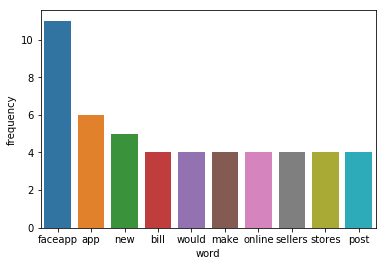

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt

# Use Seaborn to draw a word frequency chart
sns.barplot(x = "word", y = "frequency", data = word_frequency)

Text(0.5, 1.0, 'Sentiment index for the search result: FaceApp -filter:retweets')

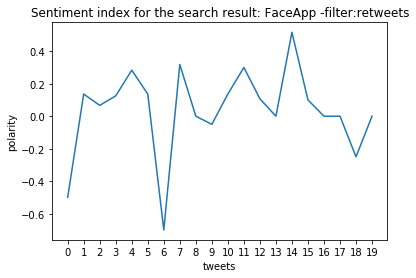

In [181]:
# Sentiment analysis with Textblob package. 

sentiment_objects = [TextBlob(tweet) for tweet in tweet_text]

sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects]

sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "tweet"])

# sentiment_df.head()

# Use Seaborn to draw a lineplot of the sentiment indices
fig = sns.lineplot(x = range(len(sentiment_df)), y="polarity", data = sentiment_df)
plt.setp(fig, xticks = range(len(sentiment_df)))
plt.xlabel("tweets")
plt.title("Sentiment index for the search result: " + keyword)

How to retrieve data from YouTube with Pytube?

In [62]:
from pytube import YouTube

In [69]:
yt = YouTube("https://www.youtube.com/watch?v=MtCMtC50gwY")

In [70]:
yt.title

'New York City Vacation Travel Guide | Expedia'

In [65]:
yt.views

'214435'

In [66]:
yt.rating

4.9205046

In [ ]:
yt.streams.all()

In [ ]:
yt.streams.first()

In [72]:
# Get all the captions 
yt.captions.all()

[<Caption lang="Chinese (Hong Kong)" code="zh-HK">,
 <Caption lang="Chinese (Taiwan)" code="zh-TW">,
 <Caption lang="Danish" code="da">,
 <Caption lang="Dutch" code="nl">,
 <Caption lang="Dutch (Belgium)" code="nl-BE">,
 <Caption lang="English" code="en">,
 <Caption lang="English (auto-generated)" code="en">,
 <Caption lang="French" code="fr">,
 <Caption lang="French (Belgium)" code="fr-BE">,
 <Caption lang="French (Canada)" code="fr-CA">,
 <Caption lang="German" code="de">,
 <Caption lang="Indonesian" code="id">,
 <Caption lang="Italian" code="it">,
 <Caption lang="Japanese" code="ja">,
 <Caption lang="ko-KR" code="ko-KR">,
 <Caption lang="Norwegian" code="no">,
 <Caption lang="Portuguese (Brazil)" code="pt-BR">,
 <Caption lang="Spanish (Mexico)" code="es-MX">,
 <Caption lang="Spanish (Spain)" code="es-ES">,
 <Caption lang="Swedish" code="sv">,
 <Caption lang="Thai" code="th">,
 <Caption lang="Vietnamese" code="vi">]

In [73]:
# Get the caption in English
caption = yt.captions.get_by_language_code("en")

In [ ]:
# Display the captions in XML, which is not easy to read. 
caption.xml_captions

In [ ]:
# Get the captions in the more readable SRT format (see https://www.speechpad.com/captions/srt). 
caption_srt = caption.generate_srt_captions()

print(caption_srt)

#save the caption to a file named Output.txt
text_file = open("YouTube_caption.txt", "w")
text_file.write(caption_srt)
text_file.close()

In [ ]:
# Create a dataframe with indices, time, and texts in separate columns. 

#Split SRT file into lines.
caption_lines = caption_srt.splitlines()
# print(caption_lines)

#Create a nested list so we can create data frame out of it. 
nested = []
#There are four lines for each item on the list. 
num_lines_per_item = 4
for ix in range(0, len(caption_lines) - num_lines_per_item, num_lines_per_item):
    nested.append(caption_lines[ix:ix + num_lines_per_item])
    
print(nested)

In [ ]:
import pandas as pd

# Create a data frame of the captions
caption_df = pd.DataFrame(nested, columns = ["index", "time", "text", "line_break"])

# Delete the the last column because it's empty. 
caption_df = caption_df.drop(columns = ["line_break"])

# Now we have a dataframe with three columns: index, time, and text. 
caption_df

In [ ]:
Sentiment analysis with TextBlob

In [ ]:
#pip install -U textblob
from textblob import TextBlob

# Send the text to TextBlob for sentiment analysis
sentiment_objects = [TextBlob(caption) for caption in caption_df["text"]]

# Retrieve sentiment values
sentiment_values = [[sentiment_obj.sentiment.polarity, str(sentiment_obj)] for sentiment_obj in sentiment_objects]

# Add a "polarity" column to the dataframe
caption_df["polarity"] = [sentiment_obj.sentiment.polarity for sentiment_obj in sentiment_objects]

caption_df

Use Seaborn to draw a sentiment timeline. 

Text(0.5, 1.0, 'Sentiment index for YouTube Video: New York City Vacation Travel Guide | Expedia')

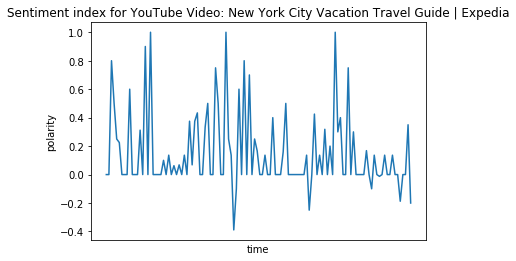

In [179]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = sns.lineplot(x = "index", y="polarity", data = caption_df)
plt.setp(fig, xticks = []) # Remove the X ticks because it's too crowded. 
plt.xlabel("time")
plt.title("Sentiment index for YouTube Video: " + yt.title)